# Generate an input scene for `meas_deblender`

We're using these bandpasses from SDSS: *u*, *g*, *r*, *i*, *z*.

In [1]:
from __future__ import print_function, division
import glob
from astropy.io import fits
import astropy.modeling.models as models
import numpy as np
from scipy import stats
import astropy.stats
import astropy.table
from astropy import wcs
from astropy import convolution
# import lupton_rgb
import img_scale

In [2]:
%matplotlib inline
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['image.interpolation'] = 'nearest'

In [3]:
import os
from os.path import exists, isdir, basename, split, join

_pysynphot_ref_file_roots = (
    '/Users/hcferguson/data/cdbs',
    '/Users/jlong/cdbs',
    '/grp/hst/cdbs'
)
if not os.environ.get('PYSYN_CDBS', False):
    for location in _pysynphot_ref_file_roots:
        if isdir(location):
            os.environ['PYSYN_CDBS'] = location

assert os.environ.get('PYSYN_CDBS', False)
import pysynphot

In [4]:
GALAXY_A_PATH = os.environ['PYSYN_CDBS'] + '/grid/bc95/templates/bc95_c_10E9.fits'
GALAXY_B_PATH = os.environ['PYSYN_CDBS'] + '/grid/bc95/templates/bc95_c_10E7.fits'
STAR_PATH = os.environ['PYSYN_CDBS'] + '/grid/pickles/dat_uvk/pickles_uk_9.fits'
SOLAR_PATH = os.environ['PYSYN_CDBS']  + '/calspec/sun_reference_001.fits'

LSST_FWHM_ARCSEC = 0.7
LSST_PIXEL_SCALE = 0.2
SDSS_BANDS = ('u', 'g', 'r', 'i', 'z')

In [5]:
def ensure_dir(dirpath):
    try:
        os.makedirs(dirpath)
    except OSError:
        if not isdir(dirpath):
            raise
    return dirpath

In [6]:
OUTPUT_PATH = './outputs/TwoGalaxies-A'
ensure_dir(OUTPUT_PATH)

'./outputs/TwoGalaxies-A'

In [7]:
from quickscene import Scene, ChromaticGaussianPSF

In [8]:
chromatic_psf = ChromaticGaussianPSF(
    fwhm_arcsec=0.7,
    reference_wavelength=pysynphot.ObsBandpass('sdss,i').avgwave()
)
hdulist = chromatic_psf.fits_for_bands('ugriz', LSST_PIXEL_SCALE)
hdulist.writeto(join(OUTPUT_PATH, 'chromatic_gaus_0.7_arcsec_sdss_i.fits'), clobber=True)
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       7   ()      
  1  U           ImageHDU        10   (25, 25)   float64   
  2  G           ImageHDU        10   (25, 25)   float64   
  3  R           ImageHDU        10   (25, 25)   float64   
  4  I           ImageHDU        10   (25, 25)   float64   
  5  Z           ImageHDU        10   (25, 25)   float64   


# Do one scene

(/grp/hst/cdbs/comp/nonhst/sdss_u_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_g_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_r_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_i_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_z_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_u_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_g_005_syn.fits) does not have a defined binset in the wavecat 

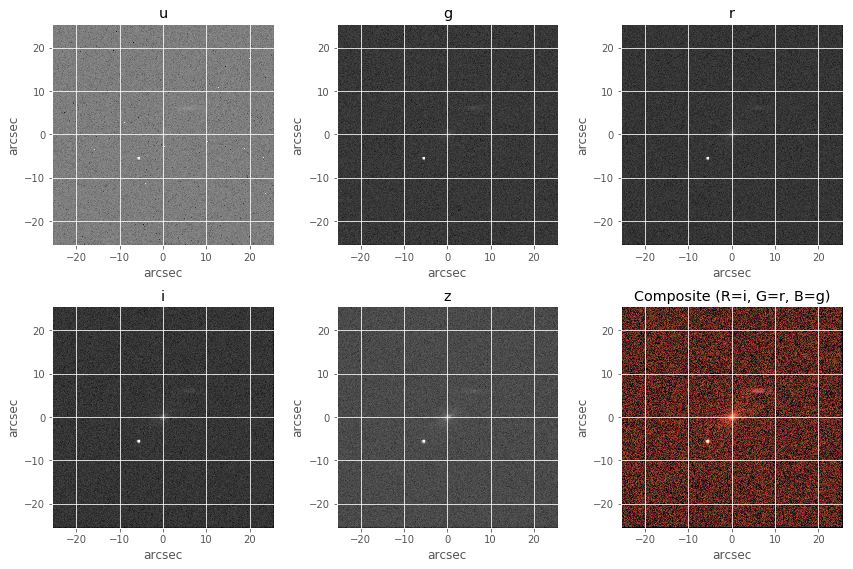

In [9]:
scene = Scene(
    chromatic_psf=chromatic_psf,
    # alternatively, constant angular size with wavelength: kernel_fwhm_arcsec=0.7,
    width_px=256,
    height_px=256,
)
scene.add_sersic_galaxy(
    spectrum=GALAXY_A_PATH,
    redshift=0.0,
    abmag=20.,
    r_eff_arcsec=25 * 0.2,
    sersic_index=4.,
    x_arcsec=0,
    y_arcsec=0,
    ellipticity=0.5,
    theta=0.6,
)
scene.add_sersic_galaxy(
    spectrum=GALAXY_B_PATH,
    redshift=0.0,
    abmag=22.,
    r_eff_arcsec=10 * 0.2,
    sersic_index=1.,
    x_arcsec=6.0,
    y_arcsec=6.0,
    ellipticity=0.8
)
scene.add_star(
    spectrum=STAR_PATH,
    abmag=20.,
    x_arcsec=-5.6,
    y_arcsec=-5.6,
)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for idx, band in enumerate(scene.bands):
    scene.display(band=band, ax=axes.flatten()[idx], norm=LogNorm())

scene.display_rgb(ax=axes.flatten()[-1], norm=LogNorm())
plt.tight_layout()

In [10]:
scene.truth_canvas.shape

(5, 512, 512)

In [11]:
scene.canvas.shape

(5, 256, 256)

# Build grid

In [12]:
BASE_MAGNITUDE = 15
BASE_REDSHIFT = 0.0

def build_scene(delta_mag, delta_z, separation, theta):
    galaxy_1_mag = BASE_MAGNITUDE
    galaxy_1_z = BASE_REDSHIFT
    galaxy_1_coords = -separation / 2., 0
    galaxy_1_theta = 0.0
    print("Galaxy 1: magnitude = {}, redshift = {}, position = {}".format(
        galaxy_1_mag,
        galaxy_1_z,
        galaxy_1_coords,
    ))
    galaxy_2_mag = BASE_MAGNITUDE + delta_mag
    galaxy_2_z = BASE_REDSHIFT + delta_z
    galaxy_2_coords = +separation / 2., 0
    galaxy_2_theta = theta
    print("Galaxy 2: magnitude = {}, redshift = {}, position = {}".format(
        galaxy_2_mag,
        galaxy_2_z,
        galaxy_2_coords,
#         galaxy_2_theta
    ))
    scene = Scene(
        chromatic_psf=chromatic_psf,
        width_px=64,
        height_px=64,
    )
    scene.add_sersic_galaxy(
        spectrum=GALAXY_A_PATH,
        redshift=BASE_REDSHIFT,
        abmag=galaxy_1_mag,
        r_eff_arcsec=25 * 0.2,
        sersic_index=4.,
        x_arcsec=galaxy_1_coords[0],
        y_arcsec=galaxy_1_coords[1],
        ellipticity=0.5,
        theta=galaxy_1_theta,
    )
    scene.add_sersic_galaxy(
        spectrum=GALAXY_B_PATH,
        redshift=BASE_REDSHIFT + delta_z,
        abmag=galaxy_2_mag,
        r_eff_arcsec=25 * 0.2,
        sersic_index=4.,
        x_arcsec=galaxy_2_coords[0],
        y_arcsec=galaxy_2_coords[1],
        ellipticity=0.5,
        theta=galaxy_2_theta,
    )
    return scene
    
scenes = []
    
for delta_magnitude in (0, 1, 2, 3): # 6 mag is ~100 fold, overkill
    for delta_redshift in (0, 1, 2):
        for separation in (0.5, 0.75, 1., 1.25):
            theta = np.pi / 2
            scene = build_scene(delta_magnitude, delta_redshift, separation, theta)
            scenes.append(scene)
            filepath = join(OUTPUT_PATH, 'delta_mag_{delta_magnitude}/delta_z_{delta_redshift:1.1f}/sep_{separation:1.3f}_arcsec.fits').format(
#                 magA=BASE_MAGNITUDE,
#                 zA=BASE_REDSHIFT,
                delta_magnitude=delta_magnitude,
                delta_redshift=delta_redshift,
                separation=separation
            )
            blend_id = 'TwoGalaxies-A--dm-{delta_magnitude}-dz-{delta_redshift:1.1f}-sep-{separation:1.3f}'.format(
                delta_magnitude=delta_magnitude,
                delta_redshift=delta_redshift,
                separation=separation
            )
            dirs, filename = split(filepath)
            ensure_dir(dirs)
            print(filename)
            hdu_list = scene.to_hdu_list(filepath)
            
            hdr = hdu_list['PRIMARY'].header
            hdr.extend((
                    ('BLEND-ID', blend_id, 'Unique identifier within the deblending datasets'),
                    ('GALAMAG', BASE_MAGNITUDE, 'ABmag of Galaxy A'),
                    ('GALAZ', BASE_REDSHIFT, 'redshift z of Galaxy A'),
                    ('DELTAMAG', delta_magnitude, 'ABmag(Galaxy B) - ABmag(Galaxy A)'),
                    ('DELTAZ', delta_redshift, 'z(Galaxy B) - z(Galaxy A)'),
                    ('SEPARATE', separation, 'center-to-center dist. between sources, arcsec'),
            ))
            hdu_list.writeto(filepath, clobber=True)
            print("saved {}".format(filepath))
            
            fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
            for idx, band in enumerate(scene.bands):
                scene.display(band=band, ax=axes.flatten()[idx], norm=LogNorm())

            scene.display_rgb(ax=axes.flatten()[-1], norm=LogNorm())
            plt.tight_layout()
            plt.savefig(filepath.replace('.fits', '.png'))
            plt.close()

Galaxy 1: magnitude = 15, redshift = 0.0, position = (-0.25, 0)
Galaxy 2: magnitude = 15, redshift = 0.0, position = (0.25, 0)
(/grp/hst/cdbs/comp/nonhst/sdss_u_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_g_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_r_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_i_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_z_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_u_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of th

saved ./outputs/TwoGalaxies-A/delta_mag_0/delta_z_0.0/sep_0.500_arcsec.fits
Galaxy 1: magnitude = 15, redshift = 0.0, position = (-0.375, 0)
Galaxy 2: magnitude = 15, redshift = 0.0, position = (0.375, 0)
(/grp/hst/cdbs/comp/nonhst/sdss_u_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_g_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_r_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_i_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_z_005_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(/grp/hst/cdbs/comp/nonhst/sdss_u_005_sy